# Machine Learning Engineer Nanodegree
## Capstone Project

**Virtual Machine (VM) preparation time prediction**

Sergey Sergeev  
March 7th, 2019

## I. Definition

### Project Overview

I work for the software development company, and we pay high attention to the test automation.
During 15 years of our product development and many implemented customer projects we accumulated a lot of autotests.
Autotests check various parts of our product in different environments, e.g. 

- Clusters of various size: 1, 2, 4, 8 virtual machines (VMs)
- RedHat Enterprise Linux (RHEL) version 6 or 7
- Different versions of Java (our primary programming language)
- etc...

Individual test's execution times vary from few minutes to several hours depending on complexity and size.

We built the private cloud (based on Openstack) for the continuous autotest execution and a simple Web interface to manage it.
On the dedicated page software engineer may choose the list of tests to be executed, a number of virtual machines, versions of the 3rdparty software to be provisioned in the VMs, and so on.

The test request is then queued to be executed as soon as possible, according to actual cloud capacity and VM consumption.

As a result, engineer receives an email with the test report.
Test reports are also stored in some shared directory for reference, comparison and further analysis needs.     

### Problem Statement

For the higher cloud capacity utilization and better user experience we would like to have a model capable to predict overall test execution time.
This time is a sum of three:

- **Queue time (`t1`)**: time spent by an execution request in the queue waiting for free cloud capacity
- **VM preparation time (`t2`)**: time to create a cluster of VMs and provision it with the requested 3rdparty software
- **Actual test execution time (`t3`)**: time to execute selected tests on the prepared VM cluster till the final report   

In this project, we would focus on `t2` estimation only, leaving `t1` and `t3` for a future.

Here is the brief workflow to prepare the solution:

- Explore and clean up data
- Prepare benchmark model for final solution evaluation
- Remove useless features - e.g. success/failure indicator, number of attempts performed
- Transform original features
- Try various regression models provided by scikit-learn
- Tune the best model parameters with grid search
- Test final model on a testing set, compare with the benchmark model


### Metrics

[R^2 regression score](https://en.wikipedia.org/wiki/Coefficient_of_determination) (coefficient of determination) would be used as the main evaluation metric.

Additionally, [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error) and [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (root mean squared error) would be used for illustrative purposes.

## II. Analysis

### Data Exploration

In [1]:
# Shared imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
np.random.seed = 42

Let's load the dataset from csv file and explore it:

In [2]:
## some corrections of auto-detected datatypes
dtype_corrections = {'with_postgresql_version': str}

data = pd.read_csv('clusters.csv', dtype = dtype_corrections)
print("The original dataset has {} data points with {} variables each.".format(*data.shape))


The original dataset has 1095 data points with 32 variables each.


In [3]:
data.dtypes

cluster_name               object
attempts                    int64
start_ts                    int64
end_ts                      int64
failed                       bool
completed                    bool
vm_count                    int64
build_name                 object
with_conda                   bool
with_conda_version         object
with_docker                  bool
with_docker_version        object
with_flavor                object
with_foundation              bool
with_foundation_version    object
with_gemfire                 bool
with_gemfire_version       object
with_image                 object
with_java_version          object
with_kubernetes              bool
with_kubernetes_version    object
with_memcached               bool
with_memcached_version     object
with_oracle                  bool
with_oracle_version        object
with_os_version            object
with_postgresql              bool
with_postgresql_version    object
with_tibco                   bool
with_tibco_ver

**Brief description of CSV columns:**

- `cluster_name`: The name of a cluster, primary key of the dataset
- `attempts`: Number of attempts performed to create and provision requested cluster, can be from `1` to `10`. The procedure gives up if a cluster is still failed after 10 subsequent attempts to build it
- `start_ts`: Start timestamp (in milliseconds from 1970, Jan, 1, 00:00:00 UTC)
- `end_ts`: End timestamp (in milliseconds from 1970, Jan, 1, 00:00:00 UTC)
- `failed`: Was it finished successfully or not?
- `completed`: Was it completed (even with failure) or interrupted?
- `vm_count`: Cluster size. Number of requested virtual machines in a cluster, can be from `1` to `26`
- `build_name`: Some unique software version identifier in our build system


Other columns (theier names are started with `with_` prefix) describe how each of a cluster machine is to be provisioned:

- `with_flavor`: Size of VM (in terms of # of CPU, RAM and HDD size)
- `with_os_version`: Operating system version to be used, can be `RHEL6.9`, `RHEL7.3` or `RHEL7.4`
- `with_image`: Custom base VM image to be used, or `_default_` in case of some pre-provisioned RHEL image is sufficient
- `with_java_version`: Java version. For example, `1.8.0_74`, `1.8.0_102`


Other `with_` columns come in pairs:

- `with_<X>` (3rdparty indicator column): Should `X` software be installed and configured or not?
- `with_<X>_version` (3rdparty version column): If `X` should be installed, which version?


For example, [`with_docker = 'True'` and `with_docker_version='18.03.1.ce'`] means Docker 18.03.1.ce should be installed. 

Note that the dataset also contains records such as [`with_docker = 'False'` and `with_docker_version='18.03.1.ce'`] - this means that no Docker is needed (version column is ignored in this case).


In [4]:
## list of optional 3rdparty software names
optional_software = [
    'conda', 'docker', 'foundation', 
    'gemfire', 'kubernetes', 'memcached', 
    'oracle', 'postgresql', 'tibco', 'ulticom'
]

Few data examples are below:

In [5]:
data.head(10)

,cluster_name,attempts,start_ts,end_ts,failed,completed,vm_count,build_name,with_conda,with_conda_version,...,with_memcached_version,with_oracle,with_oracle_version,with_os_version,with_postgresql,with_postgresql_version,with_tibco,with_tibco_version,with_ulticom,with_ulticom_version
0,kalexey.20181227174135,1,1545922452338,1545923103007,False,True,13,20181227_174049_Proj_2127259257,False,4.5.11,...,_default_,False,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
1,sdmitry.20181128184423,1,1543421316335,1543421667461,False,True,1,20181128_183651_Proj_1735463230,False,4.5.11,...,_default_,True,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_
2,igarus.20181221190350,2,1545408262310,1545409537436,False,True,14,20181220_115814_Proj_2696985,False,4.5.11,...,_default_,False,11.2.0,rhel7.4,False,9.5,False,8.4.5,True,9s65
3,sdmitry.20181211190002,1,1544544132560,1544544935177,False,True,9,20181211_161447_Proj_2631643,False,4.5.11,...,_default_,True,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_
4,abondar.20181207141530,1,1544181372440,1544181831985,False,True,4,20181207_083303_Proj_1027219150,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
5,kalexey.20181227072109,1,1545884532385,1545885127105,False,True,13,20181226_174418_Proj_2127259257,False,4.5.11,...,_default_,False,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
6,maximo.20181130172742,1,1543588116338,1543588336672,True,True,4,20181130_133648_Proj_2409,False,4.5.11,...,_default_,False,11.2.0,rhel6.9,False,9.5,False,8.4.5,False,_default_
7,edrojdina.20181206155824,1,1544102532566,1544102893012,False,True,3,20181206_143754_Proj_1027219150,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
8,nazarov.20181212152410,1,1544617573021,1544617977311,False,True,1,20181210_133821_Proj_73134446,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
9,glungu.20181212000220.16171,2,1544570912999,1544571929867,False,True,15,20181212_000220_Proj_189425416,False,4.5.11,...,_default_,False,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_


Let's introduce the **target variable**: time (in seconds) to create a cluster calculated as a difference between end and start timestamps:

In [6]:
data['create_time'] = (data['end_ts'] - data['start_ts']) / 1000 ## measured in seconds

Let's explore statistics over **numerical** columns:

In [7]:
data.describe()

,attempts,start_ts,end_ts,vm_count,create_time
count,1095.000000,1.095000e+03,1.095000e+03,1095.000000,1095.000000
mean,1.296804,1.546146e+12,1.546147e+12,5.042009,593.556932
std,1.198162,1.907391e+09,1.907442e+09,5.017708,372.183086
min,1.000000,1.543070e+12,1.543071e+12,1.000000,50.761000
25%,1.000000,1.544439e+12,1.544439e+12,1.000000,353.266000
50%,1.000000,1.545925e+12,1.545926e+12,3.000000,499.470000
75%,1.000000,1.548057e+12,1.548057e+12,9.000000,729.423000
max,10.000000,1.549356e+12,1.549356e+12,26.000000,4539.504000


Numerical feature statistics conclusions:

- Most of the cluster requests were completed in 1 attempt
- Cluster size (`vm_count`) averages are low (`median = 3` and `mean = 5`) but the tail is heavy
- There are outliers in the dataset (see max `attempts` and max `create_time`)


Now, let's look at the **boolean and categorical** columns:


In [8]:
def get_unique(df, name = ""):
    un = pd.DataFrame(df.apply(lambda x: x.nunique()), columns = ['unique values'])
    un.index.name = name
    return un

display(get_unique(data.select_dtypes(include = 'bool'), "boolean feature"))

,unique values
boolean feature,
failed,2
completed,2
with_conda,1
with_docker,2
with_foundation,2
with_gemfire,2
with_kubernetes,2
with_memcached,1
with_oracle,2


As one can see, not all possible software indicators are used in the dataset.

Let's look at the software indicator correlations:

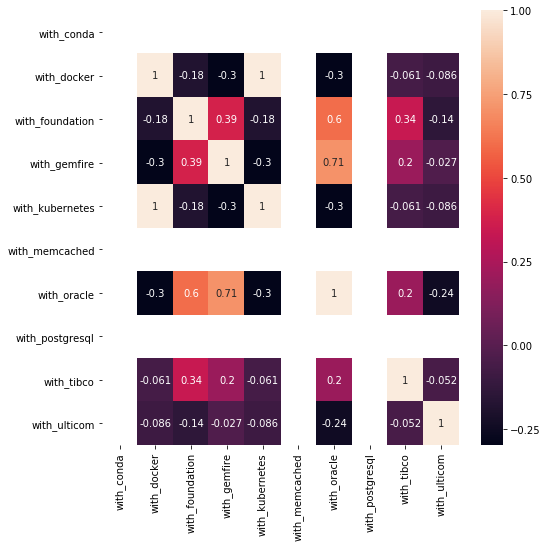

In [9]:
software_indicators = data[['with_{}'.format(x) for x in optional_software]]
corr = software_indicators.corr()

_, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot = True, ax = ax);

Conclusions about software indicator features:

- Optional software `conda`, `memcached` and `postgresql` were not used in the dataset
- `docker` and `kebernetes` were used together always as the correlation is equal to 1.0
- There is a good correlation  of `oracle` software with `gemfire` (`0.71`), and `oracle` with `foundation` (`0.6`)

Now let's explore other categorical features:

In [10]:
cat_data = data.select_dtypes(include = 'object')
software_version_cols = ['with_{}_version'.format(x) for x in optional_software]
software_versions = cat_data[software_version_cols]
other_cat_data = cat_data.drop(columns = software_version_cols)

display(get_unique(other_cat_data, 'categorical feature'))

,unique values
categorical feature,
cluster_name,1095
build_name,488
with_flavor,1
with_image,1
with_java_version,5
with_os_version,3


Conclusions:

- `with_flavor` and `with_image` are always the same, so they are useless

In [11]:
display(get_unique(software_versions, 'optional software'))

,unique values
optional software,
with_conda_version,1
with_docker_version,1
with_foundation_version,1
with_gemfire_version,5
with_kubernetes_version,1
with_memcached_version,2
with_oracle_version,1
with_postgresql_version,1
with_tibco_version,1


Conclusions above software versions:

- Most of the software versions don't vary, except of `gemfire` and `ulticom`. 
- Two versions of `memcached` looks like an error in the dataset. Anyway, `memcached` is not used as we've seen above, so can be ignored.

### Exploratory Visualization

In [12]:
plot_labels = {
    "vm_count": "Cluster size",
    "create_time": "Create time",
    "attempts": "Attempts",
}

def countplot0(x_name, data, ax):
    sns.countplot(x=x_name, data=data, ax=ax)
    ax.set_title("Observations vs. " + plot_labels[x_name])
    ax.set_xlabel(plot_labels[x_name] + " (" + x_name +")")
    ax.set_ylabel("Count")

def boxplot0(x_name, y_name, data, ax):
    sns.boxplot(x=x_name, y=y_name, data=data, ax=ax)
    x_label = plot_labels[x_name]
    y_label = plot_labels[y_name]
    ax.set_xlabel("{} ({})".format(x_label, x_name))
    ax.set_ylabel("{} ({})".format(y_label, y_name))
    ax.set_title("{} vs. {}".format(y_label, x_label))
    
def scatterplot0(x_name, y_name, data, ax):
    colors = ['red' if failed else 'green' for failed in data['failed']]
    sizes = data['attempts'] * 40
    
    ax.scatter(x=data[x_name], y=data[y_name], marker='o', sizes=sizes, c=colors, alpha=0.4)

    x_label = plot_labels[x_name]
    y_label = plot_labels[y_name]
    ax.set_xlabel("{} ({})".format(x_label, x_name))
    ax.set_ylabel("{} ({})".format(y_label, y_name))
    ax.set_title("{} vs. {}".format(y_label, x_label))

def show_plots(x_name, y_name, data):
    _, ax = plt.subplots(1, 3, figsize=(24,6))
    countplot0(x_name, data, ax[0])
    boxplot0(x_name, y_name, data, ax[1])
    scatterplot0(x_name, y_name, data, ax[2])
    

#### Creation time (`create_time`) vs. cluster size (`vm_count`)

We may expect that cluster size (`vm_count`) is the most important feature to predict cluster creation time (`create_time`). 

Let's plot it:


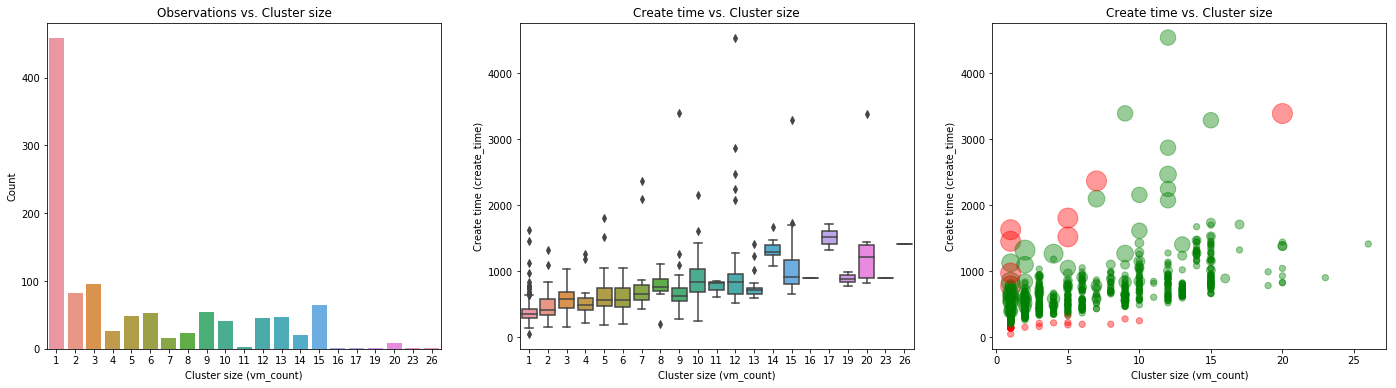

In [13]:
show_plots("vm_count", "create_time", data)

Notes on the third plot: 

- Сolors are red for `failed = True` and green for `failed = False`
- Marker size is proportional to the number of `attempts`

Conclusions from the plots above:

- About a half of the observations are for single VM clusters (`vm_count == 1`)
- We have almost no observations for large clusters (`vm_count > 15`), e.g. for `vm_count in [18, 21, 22, 24, 25]` we have no observations at all
- There are outliers for almost every cluster size
- All data for `vm_count == 14` looks like outliers if we look to the neighbours (`vm_count == 13` and `vm_count == 15`)
- Requests that were either `failed` or completed after a high number of `attempts` are mostly responsible for outliers
- Red markers at the bottom of the third plot are dataset errors. That's because cluster provisioning scripts are supposed to mark a request as failed after 10 unsuccesful attempts only. Looks like we have discovered a bug either in the scripts or in scripts logging.

#### Special case (`vm_count == 1`)

Now let's zoom in data for `vm_count == 1` - half of the dataset. 

In contrast to plots above we'll now split it over the number of `attempts`:

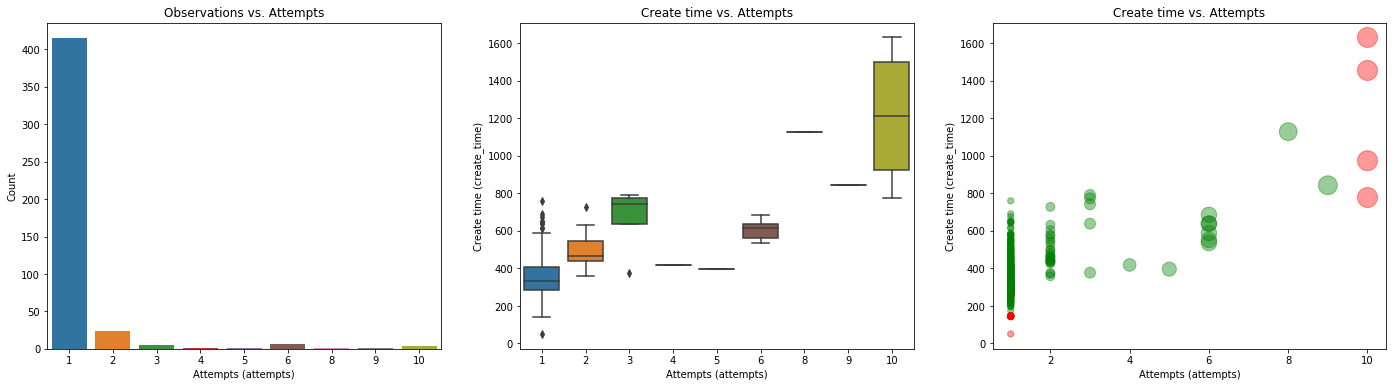

In [14]:
data_vm_count_1 = data[data['vm_count'] == 1]
show_plots("attempts", "create_time", data_vm_count_1)

Conclusions from the plots above:

- Almost half of the original observations (~430 out of 1000) are single VM cluster requests (`vm_count == 1`) completed successfully in a single attempt (`attempts == 1`)
- There are still outliers even for `attempts == 1` (see the plot in the middle)

### Algorithms and Techniques

Few scikit-learn models (available out of the box) would be checked below:

- Linear regression 
- Decision tree
- Ridge
- RANSAC, Huber and Theil-Sen regressions - promised to be good in case of data with many outliers according the [article](https://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html#sphx-glr-auto-examples-linear-model-plot-robust-fit-py])

As well as some ensemble models:

- Random forest
- Gradient boosting


### Benchmark

As a benchmark, we would use a simple model which doesn't take into account anything but cluster size (ignoring features about 3rdparty software to be provisioned).<br/>The model should calculate expected `create_time` as an average over historical data for clusters of the same size (number of VMs).


## III. Methodology

### Data Preprocessing

The first step is to remove observations that are either `failed` or completed after many `attempts`. 

Multiple attempts are usually caused by some intermittent issues in the underlying OpenStack cloud that we can't predict).

In [15]:
bad_data = data[(data['failed']) | (data['attempts'] > 5)]

bad_data_count = bad_data.shape[0]
bad_data_percent = bad_data_count * 100 / data.shape[0]
print("Found {} bad data points, {:.2f}% of the whole dataset".format(bad_data_count, bad_data_percent))
display(bad_data[['cluster_name', 'attempts', 'failed', 'vm_count', 'create_time']].head(10))

Found 60 bad data points, 5.48% of the whole dataset


,cluster_name,attempts,failed,vm_count,create_time
6,maximo.20181130172742,1,True,4,220.334
25,sdmitry.20190114185031,6,False,12,2076.067
29,marsels.20181128142358,1,True,5,225.501
35,marsels.20181204093910,10,True,1,1455.075
44,sdmitry.20190114185047,6,False,12,2872.506
70,edrojdina.20181206140532,1,True,1,144.247
71,nikolayk.20181225093155,10,True,1,1631.033
88,abondar.20190204124856,6,False,10,1614.971
135,marsels.20181128202554,10,True,5,1521.896
143,maximo.20190109104914,8,False,1,1129.215


In [16]:
good_data = data.drop(bad_data.index)
good_data_count = good_data.shape[0]
good_data_percent = good_data_count * 100 / data.shape[0]
print("We have {} good data points now, {:.2f}% of the original dataset".format(good_data_count, good_data_percent))

We have 1035 good data points now, 94.52% of the original dataset


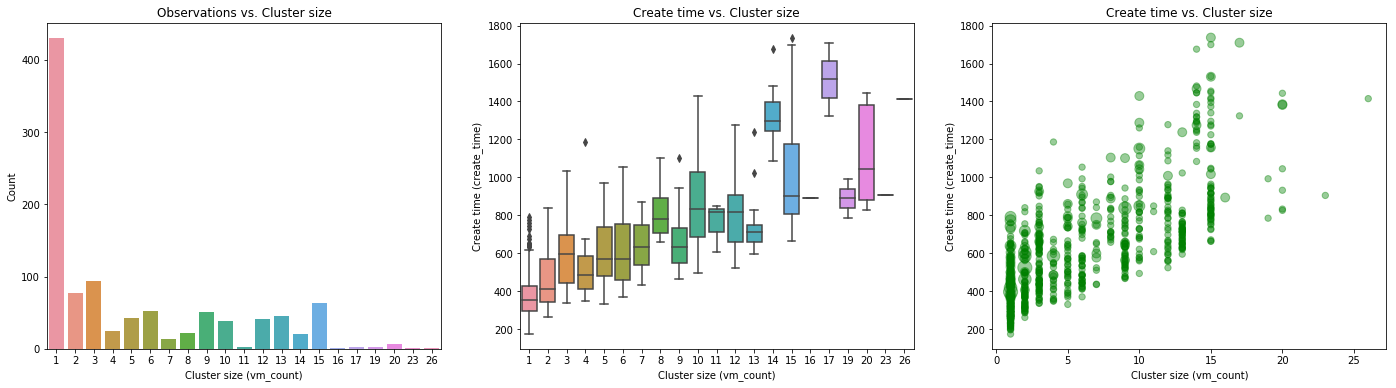

In [17]:
show_plots("vm_count", "create_time", good_data)

Now let's prepare features.

Features from original dataset to be **used**:

- `vm_count`
- `with_os_version`: Operating system version (need to be one-hot encoded further)
- `with_<X>`: Optional software indicators

Features from original dataset to be **ignored**:

- `with_flavor` and `with_image`: They are always the same in the dataset according to data analysis
- `cluster_name`: Just a primary key, no useful information
- `build_name`: Some unique version identifier, no useful information
- `with_<X>_version`: Optional software versions. Software installation procedures are almost the same for different sofware version, so we don't expect any significant change of the target variable because of version differenсe 

These features are **ignored** as well as they are actually the **outcome** of cluster provisioning, not something we know before placing a cluster request:

- `attempts`
- `start_ts`
- `end_ts`
- `failed`
- `completed`


In [18]:
# target variable
y = good_data['create_time']

# prepare feature names
feature_names = ['vm_count', 'with_os_version']
feature_names.extend(['with_{}'.format(s) for s in optional_software])
display(feature_names)

# prepare features
X = good_data[feature_names]

# one-hot encode os version
X = pd.get_dummies(X, columns = ['with_os_version'])

display(X.head(10))

['vm_count',
 'with_os_version',
 'with_conda',
 'with_docker',
 'with_foundation',
 'with_gemfire',
 'with_kubernetes',
 'with_memcached',
 'with_oracle',
 'with_postgresql',
 'with_tibco',
 'with_ulticom']

,vm_count,with_conda,with_docker,with_foundation,with_gemfire,with_kubernetes,with_memcached,with_oracle,with_postgresql,with_tibco,with_ulticom,with_os_version_rhel6.9,with_os_version_rhel7.3,with_os_version_rhel7.4
0,13,False,False,False,False,False,False,False,False,False,False,0,1,0
1,1,False,False,False,True,False,False,True,False,False,False,0,0,1
2,14,False,False,False,True,False,False,False,False,False,True,0,0,1
3,9,False,False,True,True,False,False,True,False,False,False,0,0,1
4,4,False,False,False,True,False,False,True,False,False,False,0,1,0
5,13,False,False,False,False,False,False,False,False,False,False,0,1,0
7,3,False,False,True,True,False,False,True,False,False,False,0,1,0
8,1,False,False,True,False,False,False,True,False,False,False,0,1,0
9,15,False,False,False,False,False,False,False,False,False,False,0,0,1
10,2,False,False,False,False,False,False,False,False,False,False,0,1,0


### Implementation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

## calculate metrics 
def get_scores(name, y_true, y_pred):
    df = pd.DataFrame({
        'Name' : [name],
        'R^2'  : [round(r2_score(y_true, y_pred), 4)],
        'MAE'  : [round(mean_absolute_error(y_true, y_pred), 4)],
        'RMSE' : [round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)],
    })
    return df.set_index('Name')

## train and report metrics for both train and test data
def fit_predict(models, X_train, X_test, y_train, y_test, title=""):
    for name, reg in models.items():
        reg.fit(X_train, y_train)

    print("=== Train metrics " + title + " ===")
    scores = [get_scores(name, y_train, reg.predict(X_train)) for name, reg in models.items()]
    display(pd.concat(scores))
    print("")
    print("=== Test metrics " + title + " ===")
    scores = [get_scores(name, y_test, reg.predict(X_test)) for name, reg in models.items()]
    display(pd.concat(scores))


Let's prepare the benchmark model and obtain benchmark metrics.

In [20]:
class BenchmarkModel():
    def __init__(self, avg='mean'):
        self.avg = avg 

    def fit(self, X, y):
        df = pd.concat([X, pd.Series(y, name='y')], axis=1)
        groupby = df['y'].groupby(df['vm_count'])
        if self.avg == 'mean':
            avg = pd.DataFrame(groupby.mean())
        elif self.avg == 'median':
            avg = pd.DataFrame(groupby.median())
        
        ## we may not have target data for some values of feat, so let's interpolate
        max_vm_count = 26
        avg = avg.reindex(pd.Index(range(1, max_vm_count + 1), name='vm_count'))
        avg = avg.interpolate()
        
        self.avg = avg
        return self
    
    def predict(self, X):
        df = pd.merge(X, self.avg, on='vm_count', how='left')
        return df['y']


In [21]:
benchmark_models = {
    "Benchmark (mean)"   : BenchmarkModel(avg="mean"), 
    "Benchmark (median)" : BenchmarkModel(avg="median"),
}
       
fit_predict(benchmark_models, X_train, X_test, y_train, y_test)


=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.6912,114.8219,150.8061
Benchmark (median),0.6691,111.2042,156.1141



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.7182,116.4822,152.1524
Benchmark (median),0.6810,118.1614,161.8828


**R-squared score of 0.7182 is taken as the benchmark**.

Let's check several models available in scikit-learn with their parameters set to defaults:

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, RANSACRegressor, HuberRegressor, TheilSenRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Decision Tree" : DecisionTreeRegressor(),
    "Linear" : LinearRegression(),
    "Ridge" : RidgeCV(),
    "RANSAC" : RANSACRegressor(), 
    "Huber" : HuberRegressor(),
    "Theil-Sen" : TheilSenRegressor(),
    "Random Forest" : RandomForestRegressor(n_estimators=20), 
    "Gradient Boosting" : GradientBoostingRegressor(),
}

       
fit_predict(models, X_train, X_test, y_train, y_test)

=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Decision Tree,0.8778,69.4980,94.8857
Linear,0.8229,86.2114,114.2190
Ridge,0.8229,86.2084,114.2193
RANSAC,0.8096,86.7766,118.4353
Huber,0.8177,84.0403,115.8710
Theil-Sen,0.7878,89.1348,125.0152
Random Forest,0.8732,71.9705,96.6232
Gradient Boosting,0.8621,75.8767,100.7975



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Decision Tree,0.8348,87.6430,116.4958
Linear,0.8395,85.1727,114.8359
Ridge,0.8394,85.1669,114.8499
RANSAC,0.8307,83.3356,117.9121
Huber,0.8293,85.6247,118.3986
Theil-Sen,0.7945,89.6497,129.9356
Random Forest,0.8426,85.8131,113.7093
Gradient Boosting,0.8480,83.7831,111.7428


All the selected models have obtained the R-squared score higher than benchmark on the test dataset. Among them **Gradient Boosting** has obtained the highest one.
MAE (mean absolute error) and RMSE (root mean squared error) are smallest for Gradient Boosting as well.

### Refinement

In this section, we would try two approaches to improve Gradient Boosting:

- Grid search (over some of the tunable parameters)
- Transforming target: according to the [scikit-learn article](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py), this approach can improve regressors' scores in some cases. 

In [23]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
param_grid = {
    "max_depth": [2, 3, 4],
    "n_estimators": [50, 100, 150, 200, 300],
    "learning_rate": [.05, .1, .2, .3],
    "subsample": [.8, .9, 1.0]
    }
cv = ShuffleSplit(n_splits=10, test_size=.1)
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid=param_grid, 
                           cv=cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 791 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 1491 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1793 out of 1800 | elapsed:  1.7min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  1.7min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
fit_predict({"Optimized Gradient Boosting": grid_search.best_estimator_}, X_train, X_test, y_train, y_test)


=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Optimized Gradient Boosting,0.8503,79.6706,105.0214



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Optimized Gradient Boosting,0.8549,82.8384,109.1625


Optimized Gradient Boosting obtained R-squared score (**0.8549**) just slightly different than Gradient Boosting trained with default parameter values (**0.8483**). Looks like GB's default parameters are already good enough for our dataset.

Now, let's try to transform or target variable with `log()` function before applying Gradient Boosting:

In [25]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
reg = TransformedTargetRegressor(
    regressor=GradientBoostingRegressor(),
    func=np.log, inverse_func=np.exp
)

fit_predict({"Transformed Target": reg}, X_train, X_test, y_train, y_test)


=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Transformed Target,0.8599,74.7382,101.5772



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Transformed Target,0.8486,82.0337,111.5373


Now the model obtained slightly higher R-squared score: **0.8486** (as well as lower `MAE` and `RMSE`), but it's not different significantly. 

If we recall that `MAE` is measured in seconds, the difference is just ~1.7 seconds between two models. It's not that important from end user point of view.

So after refinement attempts, let's stick to the basic **Gradient Boosting** with default parameter values.

## IV. Results

### Model Evaluation and Validation

Let's evaluate dataset feature importances:


In [26]:
reg = GradientBoostingRegressor().fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_test.columns, 'importance': reg.feature_importances_})
importance.sort_values(by='importance', ascending=False, inplace=True)
importance = importance.set_index('feature')
importance.head(10)

,importance
feature,
vm_count,0.743736
with_ulticom,0.093252
with_docker,0.054849
with_kubernetes,0.054815
with_gemfire,0.016236
with_foundation,0.013531
with_tibco,0.010548
with_os_version_rhel7.4,0.006926
with_oracle,0.003569


As expected, **`vm_count` is by far the most important feature** to predict target variable. 

Let's limit train and test datasets to have less variation of `vm_count` and check Gradient Boosting scores on these limited datasets:

- `vm_count <= 1`
- `vm_count <= 2`
- ... and so on

In [27]:
limited_scores = []
for i in range(1, 16):
    X_train_i = X_train[X_train['vm_count'] <= i]
    X_test_i = X_test[X_test['vm_count'] <= i]
    y_train_i = y_train.loc[X_train_i.index]
    y_test_i = y_test.loc[X_test_i.index]
    
    y_pred = GradientBoostingRegressor().fit(X_train_i, y_train_i).predict(X_test_i)
    limited_scores.append(get_scores("Gradient Boosting: vm_count <= {}".format(i), y_test_i, y_pred))

limited_scores.append(
    get_scores("Gradient Boosting: full dataset", y_test, 
               GradientBoostingRegressor().fit(X_train, y_train).predict(X_test)))
pd.concat(limited_scores)


,R^2,MAE,RMSE
Name,,,
Gradient Boosting: vm_count <= 1,0.1922,73.2785,102.3410
Gradient Boosting: vm_count <= 2,0.2661,72.6075,99.4223
Gradient Boosting: vm_count <= 3,0.4936,81.3403,110.6632
Gradient Boosting: vm_count <= 4,0.4897,80.8451,109.6870
Gradient Boosting: vm_count <= 5,0.5227,79.3627,107.5129
Gradient Boosting: vm_count <= 6,0.5421,80.1081,108.0107
Gradient Boosting: vm_count <= 7,0.5539,79.2495,106.6166
Gradient Boosting: vm_count <= 8,0.6215,80.1723,107.6306
Gradient Boosting: vm_count <= 9,0.6433,81.6662,108.6951


As expected, less variation of `vm_count` in the train dataset produces less accurate model, meaning lower ability to capture target variable variance. R-squared score increases with `vm_count` variation.

However, if we look at `MAE`, it's value doesn't change a lot (in interval from 72 to 83 seconds).

### Justification

Let's compare the final model with the benchmark:

In [28]:
models = {
    "Benchmark (mean)"  : BenchmarkModel(avg="mean"), 
    "Gradient Boosting" : GradientBoostingRegressor(),
}
       
fit_predict(models, X_train, X_test, y_train, y_test)

=== Train metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.6912,114.8219,150.8061
Gradient Boosting,0.8621,75.8767,100.7975



=== Test metrics  ===


,R^2,MAE,RMSE
Name,,,
Benchmark (mean),0.7182,116.4822,152.1524
Gradient Boosting,0.8478,83.8422,111.8262


According to the results above, **Gradient Boosting** model explains test dataset variance better and produces better predictions than simple benchmark model describe above.

So, this model can be taken as a first solution for the explored problem. 

Approaches to build better models are discussed below.

## V. Conclusion

### Free-Form Visualization

In this section, we'll explore our model predictions in comparison to ground truth test values:

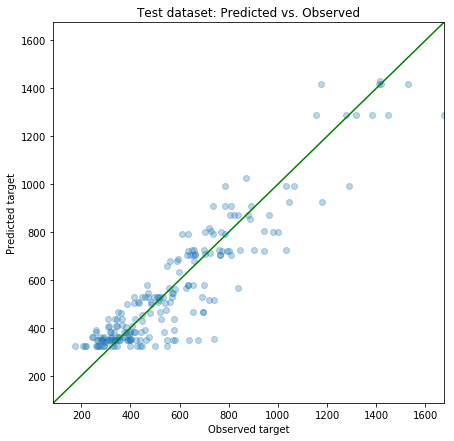

In [29]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(7,7))
    plt.title(title)
    plt.xlabel("Observed target")
    plt.ylabel("Predicted target")
    plt.scatter(x=y_true, y=y_pred, marker='o', alpha=.3)

    min_lim = min(y_true.min(), y_pred.min())/2
    max_lim = max(y_true.max(), y_pred.max())
    plt.plot([min_lim, max_lim], [min_lim, max_lim], color = 'green')
    plt.xlim(min_lim, max_lim)
    plt.ylim(min_lim, max_lim)
    plt.show()

reg = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = reg.predict(X_test)
plot_predictions(y_test, y_pred, "Test dataset: Predicted vs. Observed")

Green line on the plot above is where the observed target equals to the predicted value. Markers with positive residuals are plotted to the right of green line, negative residuals - to the left.

As one can see, markers on the left are more "condensed", while markers on the right have some outliers.


Let's filter our test data by `vm_count == 1` and plot it again for a closer look:


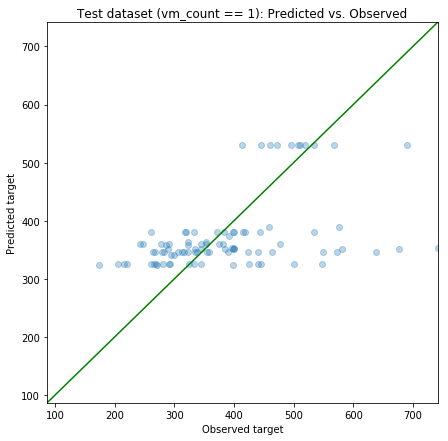

In [30]:
X_test_1 = X_test[X_test['vm_count'] == 1]
y_test_1 = y_test.loc[X_test_1.index]
y_pred_1 = reg.predict(X_test_1)

plot_predictions(y_test_1, y_pred_1, "Test dataset (vm_count == 1): Predicted vs. Observed")

Additionally, let's plot histogram and collect basic statistics about residuals obtained on the test dataset:

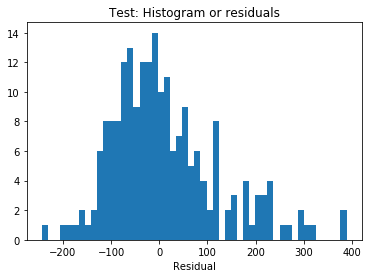

count    207.000000
mean      11.201391
std      111.495582
min     -242.976831
25%      -65.884104
50%       -9.044797
75%       61.011066
max      388.816646
Name: create_time, dtype: float64

In [31]:
residuals = y_test - y_pred

# plt.figure(figsize=(10,10))
plt.title("Test: Histogram or residuals")
plt.xlabel("Residual")
plt.hist(residuals, bins=50)
plt.show()

residuals.describe()

The histogram above (as well as calculated median) shows that our model is biased towards negative residuals. 

It means it would rather predict target value greater than actual observation. However, it's not that bad from end-user point of view if a cluster would actually get prepared earlier than predicted.

On the other hand, high positive residual outliers (right tail of histogram above) represent the opposite situation: end user would wait for his cluster longer than he was "promised" by the model. The difference could be up to ~6.5 minutes (`max = 388 seconds`). This attribute of the model is to be considered and addressed somehow when the model will be placed in production.

### Reflection

Few things I've noticed in the course of this project:

1) The most important and interesting part is the data exploration: starting from initial dataset analysis up to feature importances and residual statistics. I've also noticed how important are visualization techniques, and I wish to improve them.

2) Data exploration helped to find an issue in the cluster creation scripts, so it can be useful not only for ML purposes.

3) Feature importances detected by the model are different from what I expected intuitively. Before starting this project, I thought that 3drparty software selection is more important than it actually is.

4) Now I think that more data is needed in order to improve the model further. Few examples of additional features that could be useful: 
- current CPU/RAM/HDD load of underlying Openstack hypervisors
- VM distribution among hypervisors

Finally, let's get back to the high level problem described in the beginning:

> For the higher cloud capacity utilization and better user experience we would like to have a model capable to predict overall > test execution time.
> This time is a sum of three:
> 
> - **Queue time (`t1`)**: time spent by an execution request in the queue waiting for free cloud capacity
> - **VM preparation time (`t2`)**: time to create a cluster of VMs and provision it with the requested 3rdparty software
> - **Actual test execution time (`t3`)**: time to execute selected tests on the prepared VM cluster till the final report   
> 
> In this project, we would focus on `t2` estimation only, leaving `t1` and `t3` for a future.

It's time now to put the model in production, and continue with `t1` and `t3` prediction problems.


### Improvement

I as noted in the section above, more features need to be collected to improve the model. 


Another improvement is to train the model with "asymmetric" loss function: to penalize model more for predictions lower than actual observation. 


This is because the problem we've explored is an ETA problem, so the residual sign is important from end-user point of the view: it's better to predict target value with negative residual. 


The first approach to try could be `quantile` loss function with `alpha = .75` instead of `least squares` to train Gradient Boosting.


Besides the model improvement, we may use data exploration techniques to dig into cluster creation failures to find what caused them and how cluster creation scripts can be adjusted to avoid such failures or detect them earlier.